In [88]:
import pandas as pd
import numpy as np
from sklearn.utils._estimator_html_repr import estimator_html_repr

# SQL client

In [2]:
import os

figures = "./figures/"
os.makedirs(figures, exist_ok=True)

In [6]:
def save(fig, filename, path=figures):
    """ Savegarde une figure matplotlib """
    fig.savefig(path + filename, bbox_inches="tight")

def export_diagram(pipeline, filename):
    """ Sauvergarde le diagram d'une pipeline"""
    with open(filename, "w") as f :
        f.write(estimator_html_repr(pipeline))

# Data

Les données extraites de la base de données Azure. `Executer le script extraction.py`. On suppose que les données ont été téléchargée dans le dossier `./data/`.

In [35]:
data_path = './data/data_ext.tsv'

Chargement des données :

In [36]:
df = pd.read_csv(data_path, sep='\t', quoting=3)

In [37]:
df.head()

,Unnamed: 0,tconst,genre_1,genre_2,genre_3,primaryTitle,isAdult,startYear,runtimeMinutes,actor_1,actor_2,actor_3,director_1,director_2,director_3,averageRating,numVotes
0,0,tt6265394,Comedy,NaN,NaN,What If by SnG Comedy,False,2016,NaN,nm5106779,nm5022186,nm8595438,NaN,NaN,NaN,6.6,9.0
1,1,tt8473584,Reality-TV,NaN,NaN,Swapping Amish,False,2019,NaN,nm5819047,nm7017294,NaN,NaN,NaN,NaN,NaN,NaN
2,2,tt7161172,Adventure,Comedy,Fantasy,TableTalk,False,2017,NaN,nm5652225,nm4435805,nm4139879,NaN,NaN,NaN,NaN,NaN
3,3,tt6423374,Animation,NaN,NaN,Mpampoulas Ae,False,2012,NaN,nm0080900,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,tt7607712,Fantasy,NaN,NaN,O Filme de Schrödinger,False,2017,NaN,nm9401958,nm9402248,nm9401952,NaN,NaN,NaN,NaN,NaN


In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 669273 entries, 0 to 669272
Data columns (total 17 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Unnamed: 0      669273 non-null  int64  
 1   tconst          669273 non-null  object 
 2   genre_1         633878 non-null  object 
 3   genre_2         197851 non-null  object 
 4   genre_3         90136 non-null   object 
 5   primaryTitle    669271 non-null  object 
 6   isAdult         669273 non-null  int64  
 7   startYear       669273 non-null  int64  
 8   runtimeMinutes  407667 non-null  float64
 9   actor_1         444242 non-null  object 
 10  actor_2         394240 non-null  object 
 11  actor_3         366097 non-null  object 
 12  director_1      392268 non-null  object 
 13  director_2      36476 non-null   object 
 14  director_3      5918 non-null    object 
 15  averageRating   320451 non-null  float64
 16  numVotes        320451 non-null  float64
dtypes: float64

In [48]:
df['isAdult'] = df['isAdult'].astype(int)

# Système de Recommandation

Utilization d'un countvectorizer au lieu d'un MultiLabelBinarizer car Multilabel Binarizer n'est pas fait pour fonctionner dans une pipeline (*cf. [sckit-learn github issues 11309](https://github.com/scikit-learn/scikit-learn/issues/11309)*).

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import FunctionTransformer

In [223]:
numeric_features = ["isAdult", "startYear", "runtimeMinutes", "averageRating", "numVotes"]
categorical_features = ['genre_1', 'genre_2', 'genre_3']
text_features = ["tconst", "actor_1", "actor_2", "actor_3", "director_1", "director_2", "director_3"]

In [260]:
numeric_transformer     = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')), ('scl', StandardScaler())])
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='')), ('vec', CountVectorizer(analyzer=set))])
textual_transformer     = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='')), ('vec', CountVectorizer(analyzer=list))])

In [261]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
        ("txt", textual_transformer, categorical_features)
    ]
)

In [262]:
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scl', StandardScaler())]),
                                 ['isAdult', 'startYear', 'runtimeMinutes',
                                  'averageRating', 'numVotes']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='',
                                                                strategy='constant')),
                                                 ('vec',
                                                  CountVectorizer(analyzer=<class 'set'>))]),
                                 ['genre_1', 'genre_2', 'genre_3']),
                                ('txt',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='',
                                                                strategy='constant')),
                                                 ('vec',
                                                  CountVectorizer(analyzer=<class 'list'>))]),
                                 ['genre_1', 'genre_2', 'genre_3'])])

In [263]:
preproc_output = preprocessor.fit_transform(df)

In [264]:
filename = './data/vectorized_db.npy'

np.save(filename, preproc_output.todense())

In [309]:
class RecommanderSystem :

    def __init__(self, n=5, data_path='./data/vectorized_db.npy'):
        self._n = n
        self.load_data(data_path)
    
    def load_data(self, data_path):
        self._X = np.load(data_path, allow_pickle=True)
        print(self._X.shape)
    
    def recommand(self, idx):
        Y = self._X[idx,:].reshape(1,-1)

        result = cosine_similarity(np.delete(self._X, idx, axis=0), Y).reshape(-1)
        
        idxs = np.argpartition(result, -self._n)[-self._n:]
        idxs = idxs[np.argsort(result[idxs])]
        return idxs

In [310]:
rec = RecommanderSystem(10, filename)

(669273, 61)


In [313]:
idx = 191479
df.loc[idx, 'primaryTitle']

'Harry Potter and the Prisoner of Azkaban'

In [314]:
df.loc[rec.recommand(idx), 'primaryTitle']

495106                                          Odd Man Out
403320                                         The Tuomolat
371299                                         Go Go Squid!
453388                                      Professor White
282540    Los sueños de Elma - Historia de una madre de ...
178526         Harry Potter and the Deathly Hallows: Part 2
66027          Harry Potter and the Deathly Hallows: Part 1
501920                                My 10 Minutes Stories
45495               Harry Potter and the Chamber of Secrets
369196                                               Exodus
Name: primaryTitle, dtype: object

# Prédiction de Popularité

## utils


In [456]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

def regression_report(model, X_train, X_test, y_train, y_test):
    y_pred = model.predict(X_train)
    
    r2_train = r2_score(y_train, y_pred)
    mae_train = mean_absolute_error(y_train, y_pred)
    mse_train = mean_squared_error(y_train,y_pred)
    rmse_train = np.sqrt(mse_train)

    y_pred = model.predict(X_test)
    
    r2_test = r2_score(y_test, y_pred)
    mae_test = mean_absolute_error(y_test, y_pred)
    mse_test = mean_squared_error(y_test,y_pred)
    rmse_test = np.sqrt(mse_test)

    return pd.DataFrame({
        'r2' : [r2_train, r2_test],
        'MAE' : [mae_train, mae_test],
        'MSE' : [mse_train, mae_test],
        'RMSE' : [rmse_train, rmse_test],
        'index' : ['train', 'test'] 
    }, columns=['index', 'r2', 'MAE', 'MSE', 'RMSE']).set_index('index')

def plot_pred_actual(y, y_pred):
    fig, ax = plt.subplots()
    plt.scatter(y_pred, y, c='b', alpha=0.1)
    plt.xlabel("Prediction")
    plt.ylabel("Valeur Réelle")
    plt.title("Comparaison Réalité-Prédiction")

    return fig

class GridSearchOptimizer:
    def __init__(self, pipeline, param_grid):
        self.pipeline = pipeline
        self.param_grid = param_grid
        
        self.grid_search = None
        self.best_model = None
        self.results = None
    
    def fit(self, X_train, y_train, n_splits = 5):
        # Scoring metrics
        scoring = {
            'r2':   'r2',
            'mae':  'neg_mean_absolute_error',
            'mse':  'neg_mean_squared_error',
            'rmse': 'neg_root_mean_squared_error',
        }
        
        # Grid search
        self.grid_search = GridSearchCV(
            self.pipeline,
            self.param_grid,
            scoring=scoring,
            refit='mse',
            cv=5,
            verbose=4,
        )
        
        self.grid_search.fit(X_train, y_train)
        self.results = pd.DataFrame(self.grid_search.cv_results_)
        self.best_model = self.grid_search.best_estimator_

def display_metrics(results, params):
    return results[['param_'+ p for p in params]+['mean_fit_time', 'mean_score_time',
       'mean_test_r2','mean_test_mae',
       'mean_test_mse','mean_test_rmse']].sort_values(by=['mean_test_rmse', 'mean_test_mae'], ascending=False)


## Data prepation

In [405]:
df_ratings = df[df['averageRating'].notna()]
df_ratings.info()


<class 'pandas.core.frame.DataFrame'>
Index: 320451 entries, 0 to 669271
Data columns (total 17 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Unnamed: 0      320451 non-null  int64  
 1   tconst          320451 non-null  object 
 2   genre_1         314103 non-null  object 
 3   genre_2         141994 non-null  object 
 4   genre_3         69120 non-null   object 
 5   primaryTitle    320450 non-null  object 
 6   isAdult         320451 non-null  int64  
 7   startYear       320451 non-null  int64  
 8   runtimeMinutes  246872 non-null  float64
 9   actor_1         253580 non-null  object 
 10  actor_2         237432 non-null  object 
 11  actor_3         228699 non-null  object 
 12  director_1      218053 non-null  object 
 13  director_2      20668 non-null   object 
 14  director_3      3536 non-null    object 
 15  averageRating   320451 non-null  float64
 16  numVotes        320451 non-null  float64
dtypes: float64(3), 

In [440]:
df_y = df_ratings['averageRating']
df_X = df_ratings.drop(columns=['averageRating', 'numVotes'])

In [407]:
df_X.head()

,Unnamed: 0,tconst,genre_1,genre_2,genre_3,primaryTitle,isAdult,startYear,runtimeMinutes,actor_1,actor_2,actor_3,director_1,director_2,director_3
0,0,tt6265394,Comedy,NaN,NaN,What If by SnG Comedy,0,2016,NaN,nm5106779,nm5022186,nm8595438,NaN,NaN,NaN
5,5,tt6854792,Drama,Romance,NaN,Sriramudinta Srikrishnudanta,0,2017,129.0,nm8970446,nm8970447,nm10962932,nm8970443,NaN,NaN
6,6,tt8202912,Comedy,NaN,NaN,Every Blank Ever,0,2018,NaN,nm3643990,nm6143542,nm6682745,NaN,NaN,NaN
8,8,tt10429264,Documentary,NaN,NaN,Fabulous,0,2019,52.0,nm8838626,NaN,NaN,nm5091578,NaN,NaN
9,9,tt11274246,Drama,NaN,NaN,Bramhachari,0,2019,134.0,nm1227718,nm5724719,nm4401889,nm10021017,NaN,NaN


In [441]:
from sklearn.preprocessing import RobustScaler
# Center ratings
rscl = RobustScaler()
df_y = rscl.fit_transform(df_y.to_frame()).ravel()
df_y

array([0.        , 0.26315789, 0.36842105, ..., 0.42105263, 0.05263158,
       0.63157895], shape=(320451,))

# Test Train Split

In [442]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.3, random_state=42)

# Pipeline

In [420]:
numeric_features = ["isAdult", "startYear", "runtimeMinutes"]
categorical_features = ['genre_1', 'genre_2', 'genre_3']
text_features = ["tconst", "actor_1", "actor_2", "actor_3", "director_1", "director_2", "director_3"]

In [421]:
numeric_transformer     = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')), ('scl', StandardScaler())])
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='')), ('vec', CountVectorizer(analyzer=set))])
textual_transformer     = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='')), ('vec', CountVectorizer(analyzer=list))])

In [422]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
        ("txt", textual_transformer, categorical_features)
    ]
)

## Régression Linéaire

In [423]:
from sklearn.linear_model import LinearRegression

pipeline = Pipeline(steps=[('preproc', preprocessor), ('linreg', LinearRegression())])

params = {
    'linreg__fit_intercept' : [True, False],
}
optim = GridSearchOptimizer(pipeline, params)


In [424]:
optim.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5] END linreg__fit_intercept=True; mae: (test=-0.564) mse: (test=-0.528) r2: (test=0.146) rmse: (test=-0.727) total time=   1.1s
[CV 2/5] END linreg__fit_intercept=True; mae: (test=-0.558) mse: (test=-0.519) r2: (test=0.142) rmse: (test=-0.721) total time=   1.1s
[CV 3/5] END linreg__fit_intercept=True; mae: (test=-0.564) mse: (test=-0.529) r2: (test=0.148) rmse: (test=-0.727) total time=   1.0s
[CV 4/5] END linreg__fit_intercept=True; mae: (test=-0.559) mse: (test=-0.521) r2: (test=0.147) rmse: (test=-0.722) total time=   1.0s
[CV 5/5] END linreg__fit_intercept=True; mae: (test=-0.563) mse: (test=-0.530) r2: (test=0.149) rmse: (test=-0.728) total time=   1.0s
[CV 1/5] END linreg__fit_intercept=False; mae: (test=-0.564) mse: (test=-0.528) r2: (test=0.146) rmse: (test=-0.727) total time=   1.1s
[CV 2/5] END linreg__fit_intercept=False; mae: (test=-0.558) mse: (test=-0.519) r2: (test=0.142) rmse: (test=-0.721) total time= 

In [425]:
optim.results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_linreg__fit_intercept,params,split0_test_r2,split1_test_r2,split2_test_r2,split3_test_r2,...,std_test_mse,rank_test_mse,split0_test_rmse,split1_test_rmse,split2_test_rmse,split3_test_rmse,split4_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse
0,0.859414,0.028169,0.205335,0.002371,True,{'linreg__fit_intercept': True},0.145923,0.141737,0.147856,0.14735,...,0.004313,2,-0.726814,-0.720717,-0.72723,-0.721968,-0.727924,-0.724931,0.002977,2
1,0.850836,0.019796,0.203794,0.001478,False,{'linreg__fit_intercept': False},0.145922,0.141737,0.147856,0.14735,...,0.004313,1,-0.726814,-0.720717,-0.72723,-0.721968,-0.727924,-0.724931,0.002977,1


In [426]:
regression_report(optim.best_model, X_train, X_test, y_train, y_test)

,r2,MAE,MSE,RMSE
index,,,,
train,0.146849,0.561373,0.525318,0.724788
test,-0.100408,0.561651,0.561651,0.821040


## Regression Ridge

In [427]:
from sklearn.linear_model import Ridge

pipeline = Pipeline(steps=[('preproc', preprocessor), ('ridge', Ridge())])

params = {
    'ridge__fit_intercept' : [True, False],
    'ridge__alpha' : [1e-3, 1e-2, 1e-1, 1, 10, 100]
}
optim = GridSearchOptimizer(pipeline, params)

In [428]:
optim.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END ridge__alpha=0.001, ridge__fit_intercept=True; mae: (test=-0.564) mse: (test=-0.528) r2: (test=0.146) rmse: (test=-0.727) total time=   1.0s
[CV 2/5] END ridge__alpha=0.001, ridge__fit_intercept=True; mae: (test=-0.558) mse: (test=-0.519) r2: (test=0.142) rmse: (test=-0.721) total time=   1.1s
[CV 3/5] END ridge__alpha=0.001, ridge__fit_intercept=True; mae: (test=-0.564) mse: (test=-0.529) r2: (test=0.148) rmse: (test=-0.727) total time=   1.1s
[CV 4/5] END ridge__alpha=0.001, ridge__fit_intercept=True; mae: (test=-0.559) mse: (test=-0.521) r2: (test=0.147) rmse: (test=-0.722) total time=   1.1s
[CV 5/5] END ridge__alpha=0.001, ridge__fit_intercept=True; mae: (test=-0.563) mse: (test=-0.530) r2: (test=0.149) rmse: (test=-0.728) total time=   1.0s
[CV 1/5] END ridge__alpha=0.001, ridge__fit_intercept=False; mae: (test=-0.564) mse: (test=-0.528) r2: (test=0.146) rmse: (test=-0.727) total time=   0.9s
[CV 2/5] END r

In [429]:
optim.results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_ridge__alpha,param_ridge__fit_intercept,params,split0_test_r2,split1_test_r2,split2_test_r2,...,std_test_mse,rank_test_mse,split0_test_rmse,split1_test_rmse,split2_test_rmse,split3_test_rmse,split4_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse
0,0.861966,0.028454,0.204978,0.003036,0.001,True,"{'ridge__alpha': 0.001, 'ridge__fit_intercept'...",0.145922,0.141738,0.147858,...,0.004313,4,-0.726814,-0.720717,-0.727230,-0.721968,-0.727924,-0.724931,0.002977,4
1,0.774682,0.024233,0.147697,0.007403,0.001,False,"{'ridge__alpha': 0.001, 'ridge__fit_intercept'...",0.145922,0.141738,0.147856,...,0.004313,9,-0.726814,-0.720717,-0.727231,-0.721968,-0.727924,-0.724931,0.002978,9
2,0.852901,0.001658,0.215108,0.013295,0.010,True,"{'ridge__alpha': 0.01, 'ridge__fit_intercept':...",0.145922,0.141738,0.147858,...,0.004313,6,-0.726814,-0.720717,-0.727230,-0.721968,-0.727924,-0.724931,0.002977,6
3,0.861596,0.084333,0.173470,0.018227,0.010,False,"{'ridge__alpha': 0.01, 'ridge__fit_intercept':...",0.145922,0.141738,0.147856,...,0.004313,10,-0.726814,-0.720717,-0.727231,-0.721968,-0.727924,-0.724931,0.002977,10
4,1.124951,0.102142,0.308721,0.020347,0.100,True,"{'ridge__alpha': 0.1, 'ridge__fit_intercept': ...",0.145922,0.141738,0.147858,...,0.004313,5,-0.726814,-0.720717,-0.727230,-0.721968,-0.727924,-0.724931,0.002977,5
5,0.974651,0.060701,0.189839,0.015309,0.100,False,"{'ridge__alpha': 0.1, 'ridge__fit_intercept': ...",0.145922,0.141738,0.147856,...,0.004313,8,-0.726814,-0.720717,-0.727231,-0.721968,-0.727924,-0.724931,0.002977,8
6,1.056543,0.042448,0.294564,0.025097,1.000,True,"{'ridge__alpha': 1, 'ridge__fit_intercept': True}",0.145921,0.141738,0.147858,...,0.004313,3,-0.726815,-0.720717,-0.727230,-0.721968,-0.727924,-0.724931,0.002977,3
7,0.968750,0.033228,0.182320,0.003521,1.000,False,"{'ridge__alpha': 1, 'ridge__fit_intercept': Fa...",0.145921,0.141738,0.147856,...,0.004313,7,-0.726815,-0.720717,-0.727230,-0.721968,-0.727924,-0.724931,0.002977,7
8,1.132327,0.089765,0.303757,0.009054,10.000,True,"{'ridge__alpha': 10, 'ridge__fit_intercept': T...",0.145916,0.141739,0.147863,...,0.004312,1,-0.726817,-0.720717,-0.727228,-0.721968,-0.727920,-0.724930,0.002977,1
9,0.951170,0.041134,0.184504,0.012437,10.000,False,"{'ridge__alpha': 10, 'ridge__fit_intercept': F...",0.145915,0.141738,0.147862,...,0.004312,2,-0.726817,-0.720717,-0.727228,-0.721969,-0.727919,-0.724930,0.002976,2


In [430]:
regression_report(optim.best_model, X_train, X_test, y_train,  y_test)


,r2,MAE,MSE,RMSE
index,,,,
train,0.146849,0.561376,0.525318,0.724788
test,-0.100514,0.561649,0.561649,0.821079


## Random Forest

In [349]:
from sklearn.ensemble import RandomForestRegressor

pipeline = Pipeline(steps=[('preproc', preprocessor), ('rff', RandomForestRegressor())])

params = {
    'rff__' : l
}

optim = GridSearchOptimizer(pipeline, params)

In [350]:
optim.fit(X_train, y_train)

Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scl',
                                                                   StandardScaler())]),
                                                  ['isAdult', 'startYear',
                                                   'runtimeMinutes']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='',
                                                                                 strategy='constant')),
                                                                  ('vec',
                                                                   CountVectorizer(analyzer=<class 'set'>))]),
                                                  ['genre_1', 'genre_2',
                                                   'genre_3']),
                                                 ('txt',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='',
                                                                                 strategy='constant')),
                                                                  ('vec',
                                                                   CountVectorizer(analyzer=<class 'list'>))]),
                                                  ['genre_1', 'genre_2',
                                                   'genre_3'])])),
                ('rff', RandomForestRegressor())])

In [ ]:
optim.results

In [360]:
regression_report(pipeline, X_train, X_test, y_train, y_test)

,r2,MAE,MSE,RMSE,exp_std
index,,,,,
train,0.488385,0.769875,1.137227,1.066409,0.488387
test,0.120718,1.068134,1.068134,1.394456,0.120724


## Gradient Boosting

In [443]:
from sklearn.ensemble import GradientBoostingRegressor

pipeline = Pipeline(steps=[('preproc', preprocessor), ('gbr', GradientBoostingRegressor())])

params = {
    #"gbr__n_estimators": [50, 100, 200, 500],
    "gbr__max_depth": [2, 4, 8, 10],
    "gbr__min_samples_split": [5, 6, 10],
    #"gbr__learning_rate": [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1],
    "gbr__loss": ["squared_error"],
}

optim = GridSearchOptimizer(pipeline, params)

In [444]:
optim.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END gbr__loss=squared_error, gbr__max_depth=2, gbr__min_samples_split=5; mae: (test=-0.547) mse: (test=-0.504) r2: (test=0.185) rmse: (test=-0.710) total time=   6.4s
[CV 2/5] END gbr__loss=squared_error, gbr__max_depth=2, gbr__min_samples_split=5; mae: (test=-0.541) mse: (test=-0.494) r2: (test=0.183) rmse: (test=-0.703) total time=   6.2s
[CV 3/5] END gbr__loss=squared_error, gbr__max_depth=2, gbr__min_samples_split=5; mae: (test=-0.547) mse: (test=-0.505) r2: (test=0.186) rmse: (test=-0.711) total time=   6.1s
[CV 4/5] END gbr__loss=squared_error, gbr__max_depth=2, gbr__min_samples_split=5; mae: (test=-0.543) mse: (test=-0.498) r2: (test=0.185) rmse: (test=-0.706) total time=   6.5s
[CV 5/5] END gbr__loss=squared_error, gbr__max_depth=2, gbr__min_samples_split=5; mae: (test=-0.547) mse: (test=-0.506) r2: (test=0.187) rmse: (test=-0.712) total time=   7.3s
[CV 1/5] END gbr__loss=squared_error, gbr__max_depth=2, gbr

In [445]:
optim.results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_gbr__loss,param_gbr__max_depth,param_gbr__min_samples_split,params,split0_test_r2,split1_test_r2,...,std_test_mse,rank_test_mse,split0_test_rmse,split1_test_rmse,split2_test_rmse,split3_test_rmse,split4_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse
0,6.307387,0.390700,0.189800,0.017293,squared_error,2,5,"{'gbr__loss': 'squared_error', 'gbr__max_depth...",0.185129,0.183177,...,0.004598,10,-0.709936,-0.703103,-0.710672,-0.705734,-0.711611,-0.708211,0.003250,10
1,7.040759,0.270342,0.215593,0.010514,squared_error,2,6,"{'gbr__loss': 'squared_error', 'gbr__max_depth...",0.185129,0.183177,...,0.004598,10,-0.709936,-0.703103,-0.710672,-0.705734,-0.711611,-0.708211,0.003250,10
2,7.626585,0.272329,0.240216,0.007207,squared_error,2,10,"{'gbr__loss': 'squared_error', 'gbr__max_depth...",0.185129,0.183177,...,0.004598,10,-0.709936,-0.703103,-0.710672,-0.705734,-0.711611,-0.708211,0.003250,10
3,15.124845,0.166116,0.290455,0.032889,squared_error,4,5,"{'gbr__loss': 'squared_error', 'gbr__max_depth...",0.210644,0.207776,...,0.004088,9,-0.698733,-0.692435,-0.699348,-0.694029,-0.699282,-0.696765,0.002937,9
4,15.539213,0.952137,0.293150,0.037361,squared_error,4,6,"{'gbr__loss': 'squared_error', 'gbr__max_depth...",0.210644,0.207794,...,0.004072,8,-0.698733,-0.692427,-0.699353,-0.694030,-0.699197,-0.696748,0.002925,8
5,15.006631,0.217787,0.292590,0.026892,squared_error,4,10,"{'gbr__loss': 'squared_error', 'gbr__max_depth...",0.210950,0.207847,...,0.004062,7,-0.698597,-0.692404,-0.699311,-0.694043,-0.699276,-0.696726,0.002918,7
6,45.921430,1.260253,0.475392,0.056362,squared_error,8,5,"{'gbr__loss': 'squared_error', 'gbr__max_depth...",0.220375,0.216968,...,0.003644,3,-0.694412,-0.688406,-0.695102,-0.689916,-0.693535,-0.692274,0.002634,3
7,43.846001,0.536466,0.441730,0.011804,squared_error,8,6,"{'gbr__loss': 'squared_error', 'gbr__max_depth...",0.220877,0.217157,...,0.003635,1,-0.694189,-0.688323,-0.694971,-0.689616,-0.693319,-0.692084,0.002628,1
8,42.708212,0.571446,0.444076,0.020081,squared_error,8,10,"{'gbr__loss': 'squared_error', 'gbr__max_depth...",0.221358,0.216789,...,0.003605,2,-0.693974,-0.688485,-0.695141,-0.689645,-0.693555,-0.692160,0.002606,2
9,69.718750,1.534008,0.578571,0.077217,squared_error,10,5,"{'gbr__loss': 'squared_error', 'gbr__max_depth...",0.216589,0.213446,...,0.003838,5,-0.696096,-0.689953,-0.697128,-0.691462,-0.695139,-0.693956,0.002767,5


In [469]:
optim.results.loc[7, 'params']

{'gbr__loss': 'squared_error',
 'gbr__max_depth': 8,
 'gbr__min_samples_split': 6}

In [470]:
params = {
    "gbr__n_estimators": [100, 200, 300],
    "gbr__max_depth": [8],
    "gbr__min_samples_split": [6],
    "gbr__learning_rate": [1e-2, 1e-1, 1],
    "gbr__loss": ["squared_error"],
}

optim = GridSearchOptimizer(pipeline, params)

In [ ]:
optim.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END gbr__learning_rate=0.01, gbr__loss=squared_error, gbr__max_depth=8, gbr__min_samples_split=6, gbr__n_estimators=100; mae: (test=-0.552) mse: (test=-0.508) r2: (test=0.178) rmse: (test=-0.713) total time=  53.2s
[CV 2/5] END gbr__learning_rate=0.01, gbr__loss=squared_error, gbr__max_depth=8, gbr__min_samples_split=6, gbr__n_estimators=100; mae: (test=-0.545) mse: (test=-0.498) r2: (test=0.177) rmse: (test=-0.706) total time= 1.0min
[CV 3/5] END gbr__learning_rate=0.01, gbr__loss=squared_error, gbr__max_depth=8, gbr__min_samples_split=6, gbr__n_estimators=100; mae: (test=-0.553) mse: (test=-0.511) r2: (test=0.177) rmse: (test=-0.715) total time= 1.1min
[CV 4/5] END gbr__learning_rate=0.01, gbr__loss=squared_error, gbr__max_depth=8, gbr__min_samples_split=6, gbr__n_estimators=100; mae: (test=-0.548) mse: (test=-0.502) r2: (test=0.179) rmse: (test=-0.709) total time= 1.0min
[CV 5/5] END gbr__learning_rate=0.01, gbr__l

In [449]:
regression_report(optim.best_model, X_train, X_test, y_train, y_test)

,r2,MAE,MSE,RMSE
index,,,,
train,0.256337,0.516814,0.457902,0.676685
test,0.221223,0.527008,0.527008,0.690707


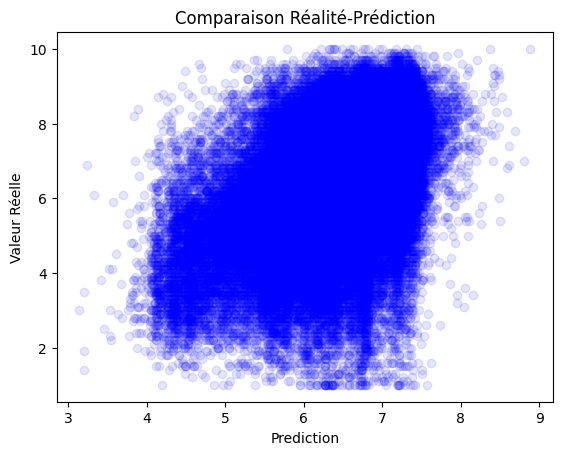

In [464]:
y_pred = rscl.inverse_transform(optim.best_model.predict(X_test).reshape(-1,1))
fig = plot_pred_actual(rscl.inverse_transform(y_test.reshape(-1,1)), y_pred)
plt.show()